# <center>Spreading disease through the air</center> 
#### <center>EE-558 - _A Network Tour of Data Science_ - Final Project</center>

***

## Students

* Team: `8`
* Students: `Matyas Lustig, Aurélien Pomini, David Salathé, Justine Weber`
* Dataset: `Flight Routes`

## Motivation

Imagine a new disease emerges and spreads quickly over our globalized world. Or that someone does it on purpose as a form of an attack. Can we predict how it propagates via the interconnected airports around the globe? We try to answer that question with the help of signal processing and spectral decomposition approach as our aim is not to find an optimal solution by copying papers already showing great result (by using SIR, Susceptible-infected-removed, models for example). In this work we present you a nice way to graphically simulate a disease attack and we attempt to find the most effective way to infect most airports. <br>

We will go through several steps :
1. [Building the network](##Building-the-network)
2. [Tools](##Building-the-network)
3. [Methods comparison](##Building-the-network)

This notebook should be read together with the corresponding report in order to understand in detail why and how we have done everything. Some part of the report have been reproduced in this notebook in order to help you understand our goal and the theory behind what we have done.

***

## Imports

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import scipy
from scipy import sparse

from mpl_toolkits.basemap import Basemap
# if you don't have it installed run : conda install -c anaconda basemap

import sys

In [6]:
# Plotting tools

# For adapting colorbar size
from mpl_toolkits.axes_grid1 import make_axes_locatable


***

## Tool functions

In [7]:
def unweight(matrix) :
    assert(isinstance(matrix, np.ndarray))
    assert(matrix.shape[0] == matrix.shape[1])
    uw = matrix.copy()
    uw[uw>0] = 1
    return uw

In [8]:
def features_from_IATA(features, active):
    """ Returns dataset of targeted airports,
    Given the list of IATA we want
    
    features : dataframe containing a columns 'IATA'
    active : dictionnary where the values are 'IATA' codes
    """
    select_feat = features[features['IATA'].isin(active.values())]
    select_feat = select_feat.reset_index(drop=True)
    
    return select_feat

***

## <center> Building the network </center>

### Description 
The network we have build for this project is structured accordingly: the nodes of our graph are airports and there is an edge between two nodes, if there is a flight route between their corresponding airports. For the purpose of this project, we have used two datasets from [**OpenFlight**](https://openflights.org/data.html).

The first one - _routes_ - has been used to build the graph in the most intuitive way: each entry of this dataset describes a flight route, defined by its airline, a source airport, a destination airport, and some others (cf. code below). We have therefore used each entry of the dataset as an edge in our graph. <br>
The second dataset - _airports_ - has been used in order to get features and labels on the nodes of our graph. Each entry of this dataset describes an airport through twelve features. Five of them have been useful for our project : _name, city, IATA, latitude, longitude_. <br>
An insight of the airports table is given below.

### Load data
In order to build the graph, we have only kept the airports which appear both in the _airports_ and in the _routes_ datasets. In fact, some entries in the _routes_ dataset have a IATA code as source or destination airport which is not referenced in the _airports_ dataset. We decided to discard these because we don't have any information on the nodes connected by these edges. Conversely, some airports from the _airports_ dataset were not referenced in the _routes_ one. Adding these nodes to our graph would have added a lot of isolated nodes, which we didn't want to exploit in our project. Therefore we have also decided to discard these. In total, there are 7184 entries in the _airports_ dataset, and 3334 distinct airports (either source or destination or both) in the _routes_ dataset. After extracting the _intersection_ between the two datasets by inner join operation, we got 3186 airports, which we call "active" airports.

In [10]:
# Load airports dataset to get the features for each node
airports_ds = pd.read_csv('data/airports.dat', header = None, encoding='utf-8', names = ["Airport ID", "Name"
                                                                                         , "City", "Country", 
                              "IATA", "ICAO", "Latitude", "Longitude", "Altitude", 
                              "Timezone", "DST", "Tz db time zone", "Type", "Source"])

# Load routes dataset to get the nodes and edges that we will use to create the network
routes = pd.read_csv('data/routes.dat', sep=',', encoding='utf-8', engine='python', 
                     names = ["Airline", "Airline_ID", "Source_airport", "Source_airport_ID", 
                              "Destination_airport", "Destination_airport_ID", "Codeshare", "Stops", "Equipment"]
                     , na_values=['\\N'])

# Take all airports ID which are listed in the routes dataset, either as destination or as source
airports = pd.concat([routes["Source_airport_ID"],routes["Destination_airport_ID"]], axis=0)
airports = airports.drop_duplicates()

# Take lines of the airport dataset, corresponding to the above airports (ie. listed in routes)
features = airports_ds[airports_ds['Airport ID'].isin(airports)]

features = features.set_index(pd.Series(range(len(features))))
features = features.assign(newidx=pd.Series(range(len(features))).values)


print("Number of airports in the airports.dat file:", len(airports_ds))
print("Number of \"active\" airports in the routes.dat file:", len(features))
features.head(4)

Number of airports in the airports.dat file: 7184
Number of "active" airports in the routes.dat file: 3186


,Airport ID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz db time zone,Type,Source,newidx
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports,0
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports,1
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports,2
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports,3


### Create the adjacency matrix
TODO Explain how we construct adjacency matrix (weighted and unweighted and why both are useful) <br>
Explain what is active_idx and why we need it : it is a "memory" for the indices of the airports that we are still tracking. This enables to know which airport the lines of the adjacency matrices correspond to, and for example to get the location of a certain node on the world map. <br><br>

As we have explained above, in the _routes_ dataset the entries have a source airport, a destination airport and an airline. Therefore the same connection from a source and destination airport is sometimes represented several times in the dataset, if several different airlines take it. We have used this to add weights to our edges.

In [11]:
# Create dataframe of source and destination IATA for each route
idx_IATA = features[['IATA', 'newidx']]
routes_srcdest = routes[['Source_airport', 'Destination_airport']]

# Left join because we preserve the airports from routes, even if you don't have features on them
idx_src = routes_srcdest.merge(right=idx_IATA, how='left', left_on='Source_airport', right_on='IATA')
idx_src_dest = idx_src.merge(right=idx_IATA, how='left', left_on='Destination_airport', right_on='IATA',
                             suffixes=['_src', '_dest']).drop(columns=["IATA_src", "IATA_dest"])

In [12]:
# Build the general adjacency matrix
n_nodes = len(features)

active_l = ["" for x in range(n_nodes)]

adjacency = np.zeros((n_nodes, n_nodes), dtype=int)
adjacency_uw = np.zeros((n_nodes, n_nodes), dtype=int)

for idx, row in idx_src_dest.iterrows():

    if pd.isnull(row.newidx_src) or pd.isnull(row.newidx_dest):
        continue
    i, j = int(row.newidx_src), int(row.newidx_dest)
    
    active_l[i] = row.Source_airport
    active_l[j] = row.Destination_airport
    
    adjacency_uw[i, j] = 1
    
    adjacency[i, j] = adjacency[i, j] + 1

#adjacency.max()
active = np.asarray(active_l)

### Cleaning and Pre-processing
We noticed that our network still comprises seven isolated nodes (see below). These nodes are present in our network because their are referenced in both datasets, but they are isolated because according to the _routes_ dataset, they are only connected to other airports which are not referenced in the _airports_ dataset and therefore were discarded. Therefore we have removed these airports from our network. <br>
In order to remove them from our network we need to remove them from the feature table and delete the corresponding rows and columns from the adjacency matrix.

In [13]:
a = adjacency.sum(axis=1)
b = adjacency.sum(axis=0)

zero_in = np.argwhere(a==0)
zero_out = np.argwhere(b==0)

print("The following values are indices of airports which are connected to nothing :")
no_connection = []

for value in zero_in :
    if np.isin(value[0],zero_out):
        no_connection.append(value[0])

# Check : the table no_connection should exactly contain the elements which 
# are represented with an empty string in active_l 
assert(no_connection == [i for i, val in enumerate(active_l) if val == ""]) 
   
print(no_connection)
print("\nTheses airports are the following:")
print(features.loc[features['newidx'].isin(no_connection), ['IATA', 'City', 'Country']])

The following values are indices of airports which are connected to nothing :
[1522, 1523, 2643, 3027, 3029, 3040, 3088]

Theses airports are the following:
     IATA              City         Country
1522  RJA       Rajahmundry           India
1523  TIR          Tirupeti           India
2643  LPS             Lopez   United States
3027  AKI             Akiak   United States
3029  TKJ               Tok   United States
3040  SPB  Charlotte Amalie  Virgin Islands
3088  AGM      Angmagssalik       Greenland


In [14]:
# CAREFULL, DON'T RUN THIS CELL SEVERAL TIMES OTHERWISE IT DROPS COLUMNS EACH TIME
features = features.drop(features.index[no_connection])
features = features.set_index(pd.Series(range(len(features))))
features = features.assign(newidx=pd.Series(range(len(features))).values)

In [15]:
# CAREFULL, DON'T RUN THIS CELL SEVERAL TIMES OTHERWISE IT DELETES ROWS & COLUMNS EACH TIME
adjacency = np.delete(adjacency, no_connection, 0)
adjacency = np.delete(adjacency, no_connection, 1)
adjacency_uw = np.delete(adjacency_uw, no_connection, 0)
adjacency_uw = np.delete(adjacency_uw, no_connection, 1)

In [16]:
# CAREFULL, DON'T RUN THIS CELL SEVERAL TIMES OTHERWISE IT DELETES ELEMENTS EACH TIME
active = np.delete(active, no_connection)

In [17]:
active = dict(enumerate(active))

### Symmetry and self-loops
We have noticed that one element on the diagonal of our adjacency matrix was non-zero. This corresponds to having a self-loop in the graph, and comes from the fact that one entry in the _routes_ dataset has the same airport both as a source and destination. We have considered this as an anomaly, as it doesn't make sense to have a self-loop for a flight route network. Therefore we have set this diagonal element to zero. <br> 

The graph we use in this project is symmetric and weighted. Originally, our data describes directed edges, with a source and a destination but we have decided to simplify our graph: each edge of our network represents a flight route, which can be taken both ways.

In summary, the edges of our graph are undirected, and the weight of each ede represents the number of airlines taking the corresponding route. Note that if an airline takes the route in both ways, it is counted twice. 


In [18]:
# Set diagonals to zero to remove self loops
adjacency[np.diag_indices_from(adjacency)] = 0
adjacency_uw[np.diag_indices_from(adjacency_uw)] = 0

In [19]:
# Build the symmetric matrices (weighted and unweighted)
adjacency_sym = adjacency + adjacency.T
#adjacency_uw_sym = adjacency_sym
#adjacency_uw_sym[adjacency_uw_sym>0] = 1
adjacency_uw_sym = unweight(adjacency_sym)

In [20]:
# the adjacency matrix we use for the project : symmetric and weighted
adj = adjacency_sym

### Extracting largest connected component
The network we got so far is composed of seven connected components.
As the goal of this project is to get an insight on how a disease can spread across our network, is doesn't make sense to keep several components which are not connected at all. Moreover, the largest connected component of our network is composed of 3154 nodes. This means most of our graph is in this component and the other components consists in 10, 4, 3 or 2 nodes. Our largest connected component is therefore a giant component and we have decided to keep it as our final network.

In the cell below, we extract this giant component. This is what we will use for the rest of the project.

In [21]:
# Extracting Largest connected component

# Create graph in networkx
G = nx.from_numpy_matrix(adj)

nx.set_node_attributes(G, active, "IATA")

# Extract largest connected component
all_comp = nx.connected_component_subgraphs(G)

# all_comp_nodes is the list of nodes indices for each component
all_comp_nodes = nx.connected_components(G)

# create a list of indices of nodes which are not in the largest component
aside_nodes = []
for nodes in all_comp_nodes:
    #print(len(nodes))
    if(len(nodes)!=3154):
        for node in nodes :
            aside_nodes.append(node)

Gc = max(all_comp, key=len)
active_c = nx.get_node_attributes(Gc,"IATA")

# Take the corresponding adjacency matrix
adj_c = np.array(nx.to_numpy_matrix(Gc))
n_nodes_c = nx.number_of_nodes(Gc)

In [22]:
adj_uw_c = unweight(adj_c)

***

## <center> Tools </center>

### Sample part of the graph for interesting insights

Note that here we use the **unweighted** adjacency matrix, i.e. we only take into account the **number of other airports** to which an airport is connected to define it as very connected or poorly connected, and not the number of flights per route.

In [23]:
def sample_by_degree(adj = adj_uw_c, threshold = 0, way='gt') :
    degrees = np.sum(adj, axis = 1)
    if way == 'gt' :
        select_idx = np.where(degrees >= threshold)[0]
        new_adj = np.delete(adj, np.where(degrees < threshold), 0)
        new_adj = np.delete(new_adj.T, np.where(degrees < threshold), 0)
    elif way == 'lt' :
        select_idx = np.where(degrees <= threshold)[0]
        new_adj = np.delete(adj, np.where(degrees > threshold),0)
        new_adj = np.delete(new_adj.T, np.where(degrees > threshold), 0)
    elif way == 'exact' :
        select_idx = np.where(degrees == threshold)[0]
        new_adj = np.delete(adj, np.where(degrees != threshold),0)
        new_adj = np.delete(new_adj.T, np.where(degrees != threshold), 0)
    else :
        raise ValueError("'way' parameter should be either gt or lt or exact," 
                         + "respectively for greater than, less than, or exactly the threshold")
    
    airports = features.index[select_idx].values
    dict_airports = {}
    for i in airports :
        i = int(i)
        dict_airports[i] = features.iloc[i]['IATA']
    
    new_deg = np.sum(new_adj, axis = 1)
    print(new_adj.shape)
    #If bug, change dict_airport with airports
    return new_adj, new_deg, dict_airports

#### Very connected (deg >= 20)

In [27]:
adj_gt20, deg_gt20, airports_gt20 = sample_by_degree(threshold = 20, way = 'gt')

(451, 451)


#### Very very connected (deg >= 170)

In [25]:
adj_gt170, deg_gt170, airports_gt170 = sample_by_degree(threshold = 170, way = 'gt')

(12, 12)


#### Very not connected (deg <= 10)

In [28]:
adj_lt1, deg_lt1,airports_lt1  = sample_by_degree(threshold = 1, way = 'lt')

(697, 697)


---

## <center> Plotting settings </center>

In [36]:
# Saving all the latitudes and longitudes in matrices
nb_airpt = n_nodes_c

features_c = features_from_IATA(features, active_c)

lats_airpt = np.zeros(nb_airpt)
lons_airpt = np.zeros(nb_airpt)

for idx, row in features_c.iterrows():
    lats_airpt[idx] = row['Latitude']
    lons_airpt[idx] = row['Longitude']

In [37]:
def plot_map(signal, scale_size=1, alpha_=0.6, colors='Reds', edges=False, adapt_size=True, legend="", 
            nodes_size_legend=False, nodes_size_legend_array=[]):
    
    assert(len(signal)==len(features_c))
           
    # Plot of the mondial map
    plt.figure(figsize=(20,20))
    mymap = Basemap(projection='cyl')

    mymap.drawmapboundary(fill_color='silver')
    mymap.fillcontinents(color='grey', lake_color='silver', ax=None, zorder=None, alpha=None)
    mymap.drawcoastlines(linewidth=0.8, linestyle='solid', color='k', antialiased=1, ax=None, zorder=None)
    mymap.drawcountries(linewidth=0.5, linestyle='solid', color='k', antialiased=1, ax=None, zorder=None)


    x_lons, y_lats = mymap(lons_airpt, lats_airpt)
    
    if adapt_size :
        size = signal
    else :
        size = 1
    
    mymap.scatter(x_lons, y_lats, marker='o', s=size*scale_size, zorder=5, alpha=alpha_, 
                  c = signal, cmap=colors)

    # plot edges
    if edges :
        for i in range(nb_airpt):
            for j in range(i):
                if (adj_c[i,j]>0) :
                    mymap.plot([x_lons[i], x_lons[j]], [y_lats[i], y_lats[j]], linewidth=1, color='w', 
                               linestyle='solid', alpha = 0.1)
    
    # create colorbar and legend
    plt.colorbar(label=legend,fraction=0.025, pad=0.04)
    
    if nodes_size_legend :
        if len(nodes_size_legend_array) == 0:
            raise ValueError("Parameters node_size_legend and node_size_legend_array must match." +
                             " If node_size_legend is set True, then node_size_legend_array must be non empty")
            return
        else :
            for a in nodes_size_legend_array:
                plt.scatter([], [], c='k', alpha=0.5, s=a, label= str(a))
            
            plt.legend(scatterpoints=1, frameon=False, labelspacing=1, loc='lower left')
    else :
        if len(nodes_size_legend_array) != 0:
            print("Value of parameter nodes_size_legend is set at False by default." +
                  " Parameter node_size_legend_array is therefore ignored.")
    

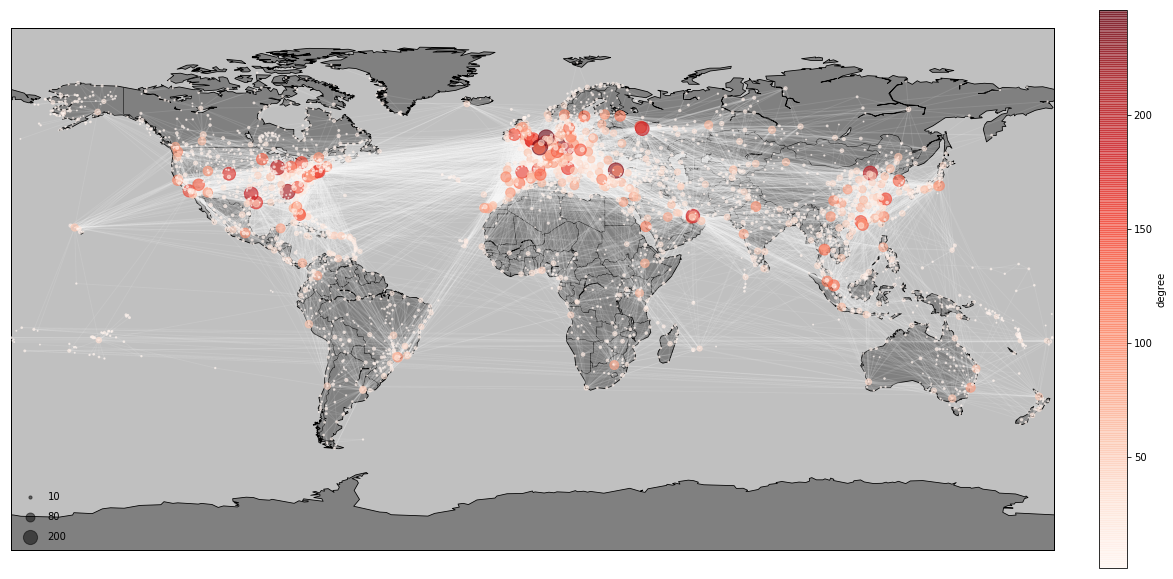

In [38]:
# Plot of the mondial map
connectivity = np.sum(adj_uw_c, axis = 1)

plot_map(connectivity, edges=True, nodes_size_legend=True, 
         nodes_size_legend_array=[10, 80, 200], legend = "degree")

## Creates labels

In [97]:
# 1. South-North
# 2. Continent
# 3. Laplacian clustering
# 4. Degree of nodes (importance of airports)
# 5. use you imagination!

In [98]:
# build solid emebedding: eg degree > 20
# plot signal on it and check 

In [99]:
# Build an embedded version in 2d
# build the clusters with sk-learn (with 3 or 6, see correction)
# Put signals and see how it brights the clustered plot
# and try to recover the same plot (with colors) with a good label (signal) > try several

# Small tips:
# try an equivalent of seaborn for plots
# (...)

# Our orininality will be on good choice of labels!

In [100]:
# Do something with airlines ?
# Keep only direct flights ("stops"=0)

In [101]:
# SUBJECT IDEA
# How to select the x airports to progagpate an illness most rapidly/efficiently

In [102]:
def continent_convert(c):
    # E (Europe), A (US/Canada), S (South America), O (Australia), Z (New Zealand), N (None) or U (Unknown)
    switcher = {
        'E' : 1,
        'A': 2,
        'S': 3,
        'O': 4,
        'Z': 5,
        'N': 6,
        'U': 0
    } 
    return switcher.get(c, "Invalid label")

In [103]:
north_south = features_c["Latitude"].apply(lambda x: -1 if x < 0 else 1)
continent = features_c["DST"].apply(continent_convert)

In [104]:
def size_convert(c):
    switcher = {
        "large_airport" : 30, 
        "medium_airport" : 10, 
        "small_airport": 5, 
        "seaplane_base" : 3, 
        "closed" : 2, 
        "heliport": 1,
        "unknown" : 0
    }
    return switcher.get(c, "Invalid label")

In [105]:
types = pd.read_csv('data/airports_type.csv')
types = types[pd.notnull(types['iata_code'])].set_index('iata_code')["type"]

types_label = []

labels = {"large_airport", "medium_airport", "small_airport", "seaplane_base", "closed", "heliport"}

for v in active_c.values():
    try:
        label = str(types.loc[v])
        if label not in labels:
            label = 'unknown'
    except:
        label = 'unknown'

    types_label.append(size_convert(label))



In [106]:
types_label

[10,
 10,
 10,
 10,
 30,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 30,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 30,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 30,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 30,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 30,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 30,
 30,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 30,
 10,
 10,
 10,
 10,
 10,
 30,
 10,
 10,
 30,
 10,
 10,
 30,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 30,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 30,
 10,
 10,
 10,
 10,
 30,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 30,
 30,
 10,
 10,
 10,
 10,
 10,
 30,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 30,
 30,
 30,
 10,
 30,
 30,
 10,
 30,
 30,
 30,
 30,
 30,
 0,
 30,
 30,
 10,
 

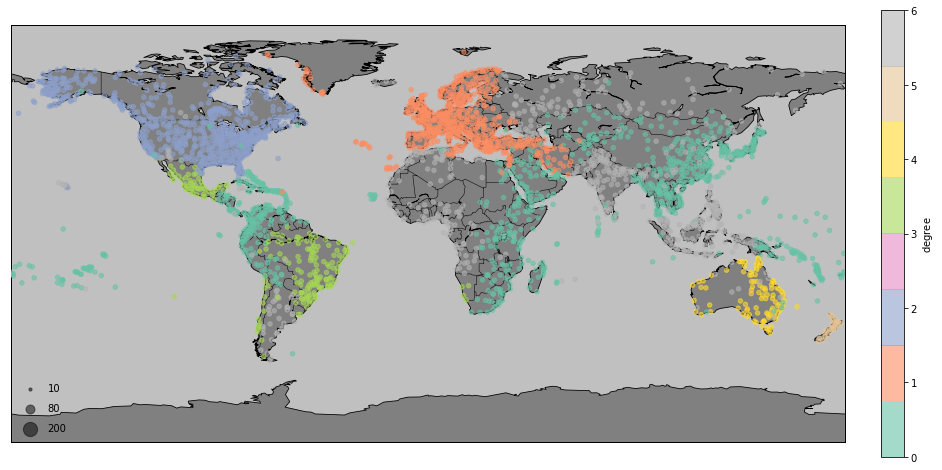

In [107]:
plot_map(continent, colors='Set2', scale_size=20, adapt_size=False)

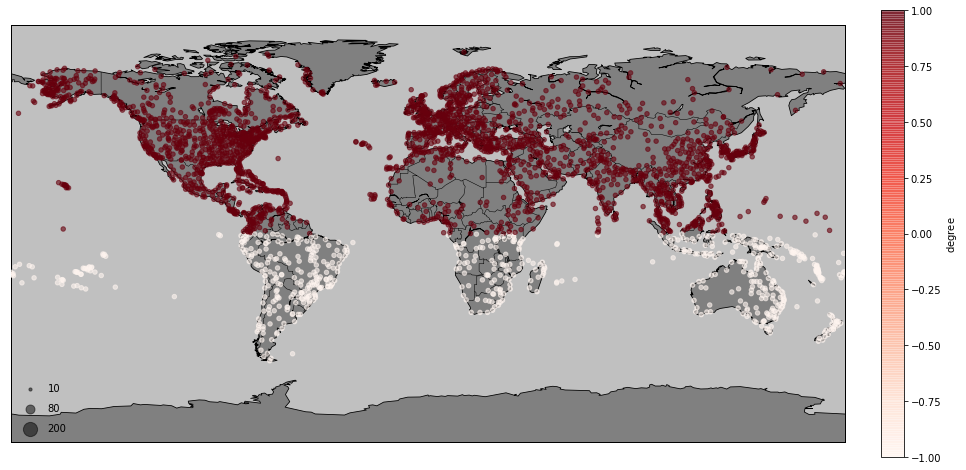

In [108]:
plot_map(north_south, colors='Reds', scale_size=20, adapt_size=False)

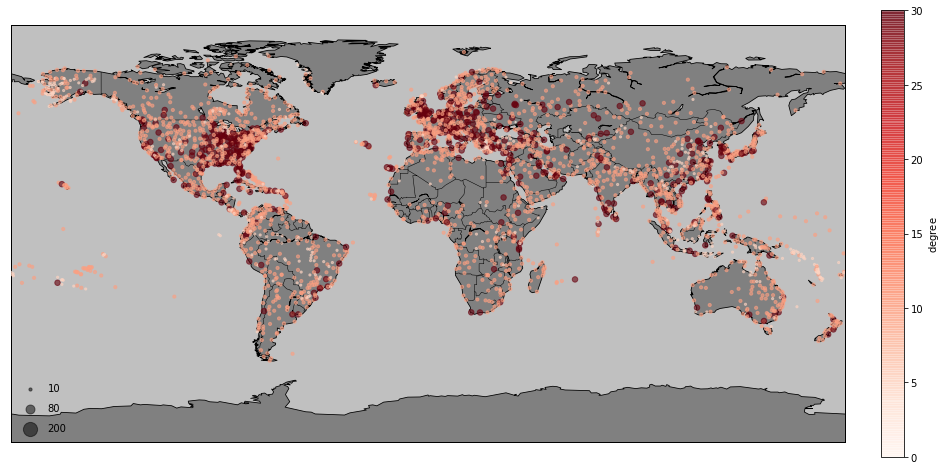

In [109]:
plot_map(types_label, colors = 'Reds', scale_size = 5, adapt_size=True)

---

# <center> Methods comparison </center>

---
## <center> Methods tools </center>
### Spectral clustering

In [111]:
from sklearn.cluster import KMeans

def spectral_clustering(adjacency, k, d):
    
    laplacian_c = sparse.csgraph.laplacian(adjacency, normed=True)
    e, U = scipy.linalg.eigh(laplacian_c)
    clusters = k
    k_eig_val, k_eig_vect = scipy.sparse.linalg.eigsh(laplacian_c, k=d, which='SM')
    # Normalizing by the degree
    #print(k_eig_vect.shape)
    diag = np.diag(laplacian_c)
    for i in range(d):
        k_eig_vect[:, i] /= diag
    inter = KMeans(n_clusters=clusters, random_state=0).fit_predict(k_eig_vect)
    Z = np.array(inter)
    print("0's:", np.count_nonzero(Z==0) )
    print("1's:", np.count_nonzero(Z==1))
    print("2's:", np.count_nonzero(Z==2) )
    return Z

In [112]:
def spectral_plot(airports, adjacency, k=3, d=10, features=features, title="Spectral Clustering"):
    """
    airports: dictionary of airports corresponding to those on the chosen adjacency
    adjacency: entries of airports chosen to be plot
    k: number of clusters desired
    d: embedding of adjacency matrix (you can keep it low, features are extremely dependent)
    features: basic database having lattitude, longitude, etc
    title: title of plot.
    
    @return: Z, result of clustering of each nodes
    """
    Z = spectral_clustering(adjacency, k, d)
    print("Shape of adjacency:", adjacency.shape)
    print("shape of Z: ", Z.shape)
    nb_airpt = len(airports)
    features_c = features_from_IATA(features, airports)
    lats_airpt = np.zeros(nb_airpt)
    lons_airpt = np.zeros(nb_airpt)


    for idx, row in features_c.iterrows():
        lats_airpt[idx] = row['Latitude']
        lons_airpt[idx] = row['Longitude']
    # Plot of the mondial map
    fig = plt.figure(figsize=(20, 20))
    mymap = Basemap(projection='cyl')

    mymap.drawmapboundary(fill_color='silver')
    mymap.fillcontinents(color='grey', lake_color='silver', ax=None, zorder=None, alpha=None)
    mymap.drawcoastlines(linewidth=0.8, linestyle='solid', color='k', antialiased=1, ax=None, zorder=None)
    mymap.drawcountries(linewidth=0.5, linestyle='solid', color='k', antialiased=1, ax=None, zorder=None)


    x_lons, y_lats = mymap(lons_airpt, lats_airpt)



    mymap.scatter(x_lons, y_lats,latlon=True, marker='o', s=30, zorder=5, alpha=0.6, 
                  c=Z, cmap='brg')

    plt.colorbar(label=r'${\rm degree}$',fraction=0.025, pad=0.04)
    plt.title(title)
    return Z



0's: 3088
1's: 45
2's: 21
Shape of adjacency: (3154, 3154)
shape of Z:  (3154,)


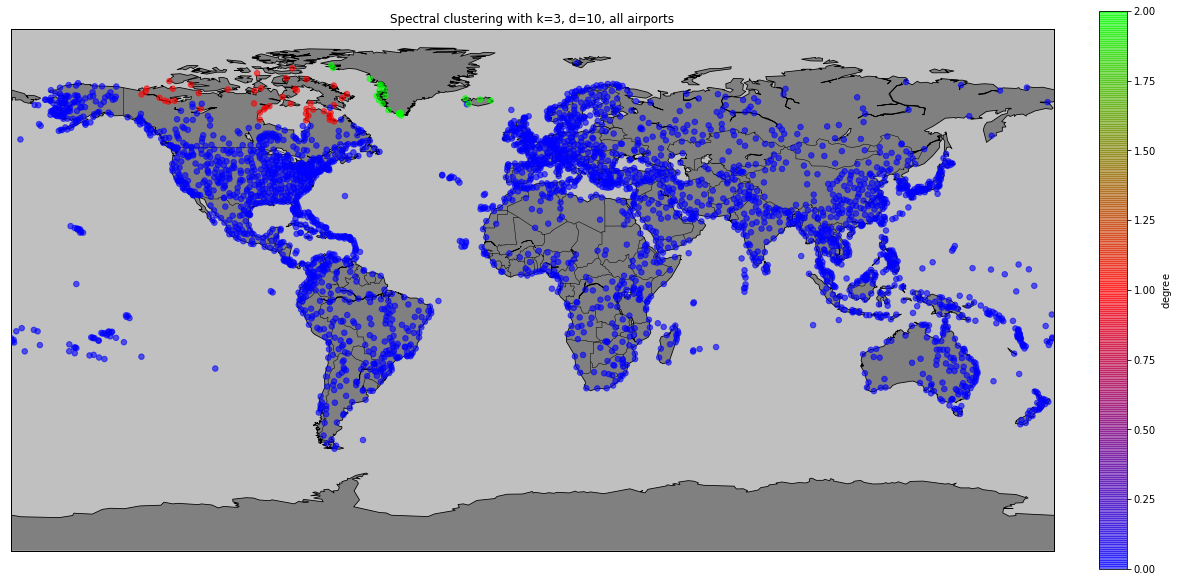

In [113]:
Z = spectral_plot(active_c, adj_c, title="Spectral clustering with k=3, d=10, all airports")
#spectral_plot(airports_gt20, adj_gt20)

(3081, 3081)
0's: 2656
1's: 22
2's: 58
Shape of adjacency: (3081, 3081)
shape of Z:  (3081,)


array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

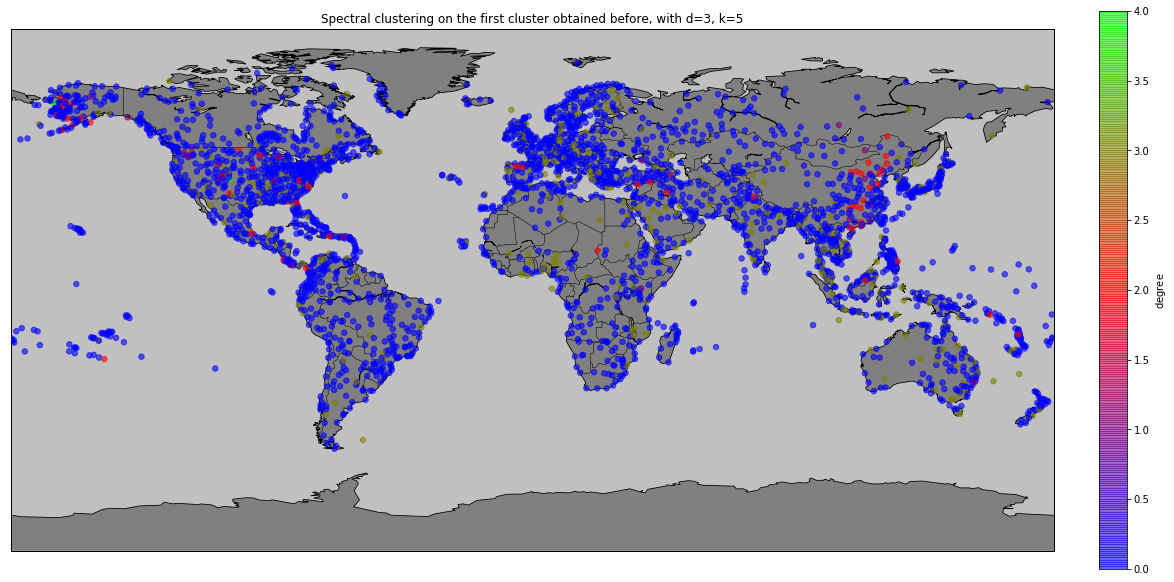

In [114]:
# Keeping first cluster only and doing it again:
def sample_by_idx(adj, select_idx) :
    new_adj = adj[select_idx]
    new_adj = new_adj[:, select_idx]
    
    # Extracting Largest connected component

    # Create graph in networkx
    G = nx.from_numpy_matrix(new_adj)

    nx.set_node_attributes(G, active, "IATA")
    #nx.set_node_attributes(G, types_dict, "type")

    # Extract largest connected component
    all_comp = nx.connected_component_subgraphs(G)

    # all_comp_nodes is the list of nodes indices for each component
    all_comp_nodes = nx.connected_components(G)


    Gc = max(all_comp, key=len)
    dict_airports = nx.get_node_attributes(Gc,"IATA")

    # Take the corresponding adjacency matrix
    new_adj = np.array(nx.to_numpy_matrix(Gc))
    
    new_deg = np.sum(new_adj, axis = 1)
    print(new_adj.shape)
    return new_adj, new_deg, dict_airports

first_cluster_adj, _, first_cluster_airports = sample_by_idx(adj_c, np.where(Z==0)[0])
spectral_plot(first_cluster_airports, first_cluster_adj, d=3, k=5, 
              title="Spectral clustering on the first cluster obtained before, with d=3, k=5")

(612, 612)
0's: 155
1's: 203
2's: 157
Shape of adjacency: (612, 612)
shape of Z:  (612,)


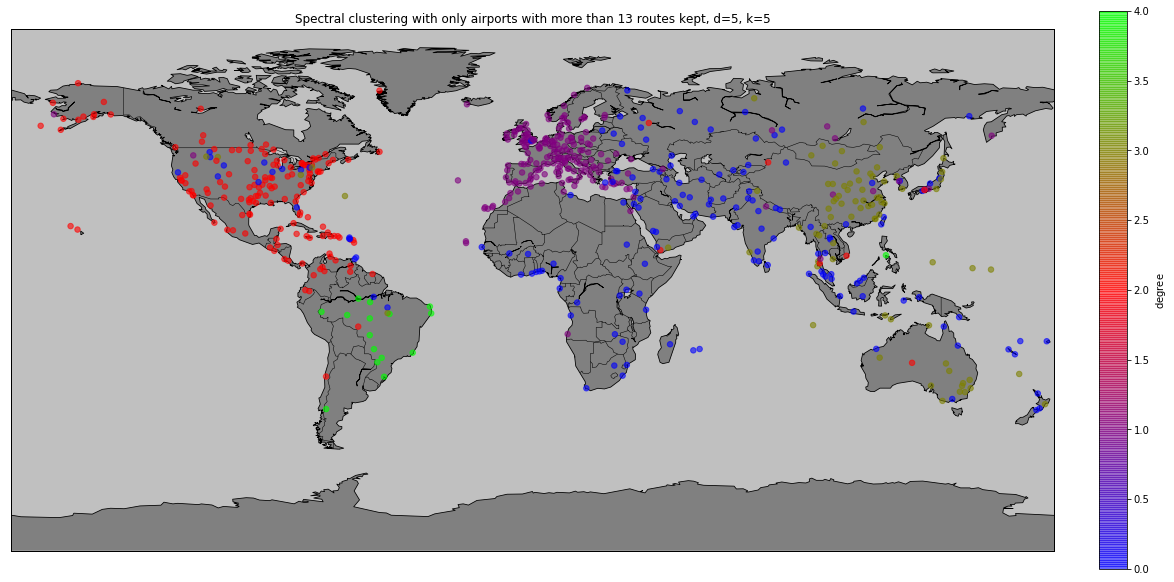

In [115]:
adj_gt13, deg_gt13, airports_gt13 = sample_by_degree(threshold = 13, way = 'gt')

Z = spectral_plot(airports_gt13, adj_gt13, d=5, k=5, 
                 title="Spectral clustering with only airports with more than 13 routes kept, d=5, k=5")

### Graph Signal Processing

In [39]:
def GFT(x):
    return U.T.dot(x)

def iGFT(x):
    return U.dot(x)


def heat_kernel(e, t):
    return np.exp(-t*e)

def inverse_kernel(e, t):
    return np.diag(np.linalg.inv(np.identity(n_nodes_c) + t*np.diag(e)))

def rectangle_kernel(e, l_min, l_max):
    f = np.vectorize(lambda x: 1.0 if x >= l_min and x <= l_max else 0.0)
    return f(e)

def graph_filter(x, kernel, **kwargs):    
    return iGFT(GFT(x) * kernel(e=e, **kwargs))

t_heat = 0.15
t_inv = 0.35
lmin = 0.0
lmax = 1.1

def metric_propag(signal, threshold):
    return np.count_nonzero(signal[signal>threshold])


def kernel_map(init_signal, scale_size = 100, adapt_size=True, t_heat=t_heat, t_inv=t_inv, lmin=lmin,
               lmax=lmax, kernels="all", metric_threshold=300) :
    
    if kernels == "all" or kernels == "heat":
        print("----------------HEAT----------------")
        heat = graph_filter(init_signal, heat_kernel, t=t_heat)
        print(heat.shape)
        
        ### PROBLEM OF INDICES !!! heat is 0 to 3154 but active_c has gaps
        
        print("Metric :", metric_propag(heat, metric_threshold))
        
        idx_max = np.flip(np.argsort(heat)[-8:])
        iata = [active[idx] for idx in idx_max]
        print("8 most represented airports :")
        print(idx_max, heat[idx_max])
        #for idx in idx_max :
         #   print(features.loc[features['IATA'] == active_c[idx]][['City', 'Country', 'IATA']])
        main_airpt = features.loc[features['IATA'].isin(iata)][['City', 'Country', 'IATA']]
        main_airpt.reindex(idx_max)
        print(main_airpt)
        plot_map(heat, scale_size = scale_size, adapt_size=adapt_size)
        print()

    #if kernels == "all" or kernels == "inverse":
     #   inverse = graph_filter(init_signal, inverse_kernel, t=t_inv)
      #  plot_map(inverse, scale_size = scale_size, adapt_size=adapt_size)

    if kernels == "all" or kernels == "rectangle":
        print("--------------RECTANGLE--------------")
        rectangle = graph_filter(init_signal, rectangle_kernel, l_min=lmin, l_max = lmax)
        
        print("Metric :", metric_propag(rectangle, metric_threshold))
        
        idx_max = np.flip(np.argsort(rectangle)[-8:])
        active[idx]
        iata = [active[idx] for idx in idx_max]
        print("8 most represented airports :")
        print(rectangle[idx_max])
        print(features.loc[features['IATA'].isin(iata)][['City', 'Country', 'IATA']])
        plot_map(rectangle, scale_size = scale_size, adapt_size=adapt_size)

In [118]:
import random
laplacian_c = sparse.csgraph.laplacian(adj_c, normed=True)
e, U = scipy.linalg.eigh(laplacian_c)


---
## <center> Method comparison </center>
### Top 5 highest degree

(3154,)
Score : 493
----------------HEAT----------------
(3154,)
Metric : 493
8 most represented airports :
[1877 1802  255  628 1635 1705 1862 1786] [0.17434943 0.17374834 0.17330814 0.17325219 0.17290798 0.00219541
 0.00210628 0.00208844]
            City         Country IATA
255       London  United Kingdom  LHR
628        Paris          France  CDG
1635    Canberra       Australia  CBR
1705     Madison   United States  MSN
1786  Providence   United States  PVD
1802      Austin   United States  AUS
1862     Killeen   United States  GRK
1877     Modesto   United States  MOD



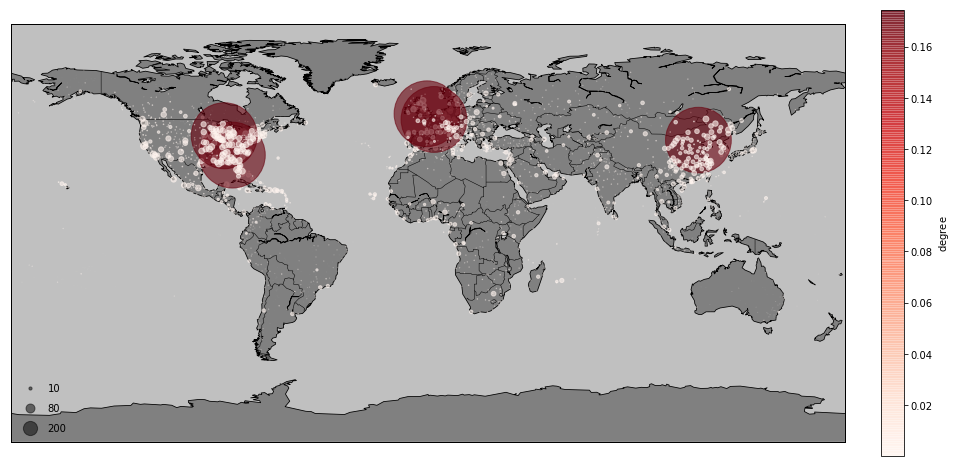

In [119]:

dirac = np.zeros(U.shape[0])
degrees = np.sum(adj_c, axis=0)
top5 = degrees.argsort()[-5:][::-1]

for i in range(5):
    
    dirac[top5[i]]=1/top5.shape[0]


heat = graph_filter(dirac, heat_kernel, t=t_heat)
print(heat.shape)

### PROBLEM OF INDICES !!! heat is 0 to 3154 but active_c has gaps
score = metric_propag(heat, 1/3154)
print("Score :", score)
kernel_map(dirac, scale_size= 25000, kernels="heat", metric_threshold=1/(3154))

### Bruteforce

In [120]:
def bruteforce():
    size = U.shape[0]
    dirac = np.zeros(U.shape[0])
    bestComb = list()
    bestScore = 0
    for i in range(size):
        for j in range(size):
            for k in range(size):
                for l in range(size):
                    for m in range(size):
                        dirac = np.zeros(U.shape[0])
                        dirac[i] = 1/5
                        dirac[j] = 1/5
                        dirac[k] = 1/5
                        dirac[l] = 1/5
                        dirac[m] = 1/5
                        heat = graph_filter(dirac, heat_kernel, t=t_heat)
                        score = metric_propag(heat, 1/3154)
                        if score > bestScore:
                            bestComb = (i, j, k, l, m)
                            bestScore = score
    print(bestComb)
    print(bestScore)

(612, 612)
0's: 76
1's: 140
2's: 35
----------------HEAT----------------
(3154,)
Metric : 552
8 most represented airports :
[1853 1802 2007  282 1635 1775 2855 1899] [0.17292123 0.17254216 0.17250281 0.17242578 0.17242    0.00583131
 0.00476124 0.00476124]
                City        Country IATA
282        Amsterdam    Netherlands  AMS
1635        Canberra      Australia  CBR
1775  St. Petersburg  United States  PIE
1802          Austin  United States  AUS
1853          Denver  United States  DEN
1899           Sitka  United States  SIT
2007         Bozeman  United States  BZN
2855        Mekoryuk  United States  MYU



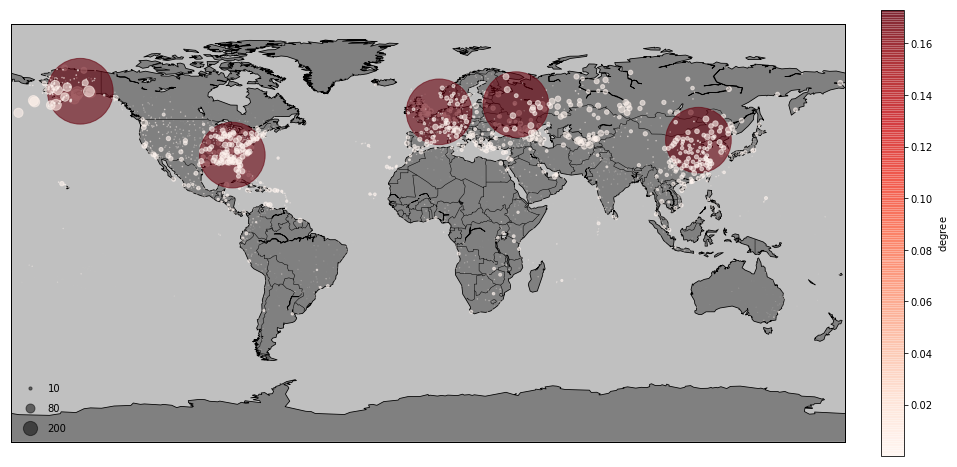

In [121]:
print(adj_gt13.shape)
clusters = spectral_clustering(adj_gt13, k=5, d=10)
best_indexes = []
for label in range(5):
    indexes, = np.where(clusters == label)
    
    best_score = 0
    best_idx = -1
    for idx in indexes:
        
        adj_idx = list(airports_gt13.keys())[idx]
        dirac = np.zeros(n_nodes_c)
        
        dirac[adj_idx] = 1
        
        filtered = graph_filter(dirac, heat_kernel, t=t_heat)
        score = metric_propag(filtered, threshold=1/3154)
        if score > best_score:
            best_score = score
            best_idx = adj_idx
    best_indexes.append(best_idx)
best_dirac = np.zeros(n_nodes_c)
for idx in best_indexes:
    best_dirac[idx] = 1/len(best_indexes)
    
kernel_map(best_dirac, scale_size= 25000, kernels="heat", metric_threshold=1/(3154))

In [122]:
[features.iloc[i] for i in best_indexes]

[Airport ID                                   3355
 Name               Canberra International Airport
 City                                     Canberra
 Country                                 Australia
 IATA                                          CBR
 ICAO                                         YSCB
 Latitude                                 -35.3069
 Longitude                                 149.195
 Altitude                                     1886
 Timezone                                       10
 DST                                             O
 Tz db time zone                  Australia/Sydney
 Type                                      airport
 Source                                OurAirports
 newidx                                       1635
 Name: 1635, dtype: object,
 Airport ID                                           3673
 Name               Austin Bergstrom International Airport
 City                                               Austin
 Country                      